title: "GWAS_Cell_Type_Gene_Sig"
author: "Fallon Ratner"
date: '2024-01-12'

## Setting Up

- Load libraries
- Load Gene Expression Dataframe (Fetal Brain Cell Types from Zhong et al., 2018)

In [3]:
import os
import pandas as pd
from io import StringIO
import seaborn as sns
from matplotlib_venn import venn2, venn2_circles
import matplotlib.pyplot as plt
from biomart import BiomartServer

#select relevant working directory
os.chdir("C:/Users/fallo/OneDrive/Documents/URF_2023/FUMA_Results")

#Read in the file with cell types, genes (ENSEMBL IDs), and gene expression
expression_data = pd.read_csv('GSE104276_Human_Prefrontal_cortex_per_ages.txt', sep='\t')

#View part of table
expression_data.head()

,GENE,GW08_Neurons,GW08_Stem_cells,GW08_GABAergic_neurons,GW08_Microglia,GW09_Stem_cells,GW09_Neurons,GW09_GABAergic_neurons,GW10_Neurons,GW10_Stem_cells,...,GW23_Astrocytes,GW23_Stem_cells,GW23_Microglia,GW26_GABAergic_neurons,GW26_Astrocytes,GW26_Neurons,GW26_Microglia,GW26_OPC,GW26_Stem_cells,Average
0,ENSG00000121410,0.164659,0.0,0.0,0.000000,0.055522,0.813748,0.0,1.046958,0.855689,...,1.373708,0.0,0.000000,0.779467,0.262848,0.211275,0.343823,0.379978,0.00000,0.479064
1,ENSG00000268895,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.116426,0.121927,0.000000,0.230800,0.000000,0.00000,0.017904
2,ENSG00000148584,0.000000,0.0,0.0,0.000000,0.049346,0.000000,0.0,0.000000,0.041276,...,0.000000,0.0,0.000000,0.086859,0.136653,0.127822,0.103129,0.039556,0.00000,0.024159
3,ENSG00000175899,1.360285,0.0,0.0,9.878978,0.386159,0.402109,0.0,0.386600,0.725723,...,0.404554,0.0,10.095362,1.305558,1.250862,0.784650,9.344341,1.352859,2.71995,2.461425
4,ENSG00000245105,0.000000,0.0,0.0,0.836778,0.000000,0.000000,0.0,0.120538,0.107940,...,0.000000,0.0,1.266793,0.188387,0.171241,0.291190,0.608301,0.145715,0.00000,0.171715


## Plot the Most Highly Expressed Genes

- Select Cell Types Significantly Associated with SCZ GWAS
- Identify the 20 Most Highly Expressed Genes per Cell Type
- Convert Ensembl IDs to Gene Names
- Plot 20 Most Highly Expressed Genes per Cell Type

In [4]:
# Select Cell Types Significantly Associated with SCZ GWAS
# Identify the 20 Most Highly Expressed Genes per Cell Type
# List of signficant cell types from fuma
sig_cell_types = ['GW26_GABAergic_neurons', 'GW23_GABAergic_neurons', 'GW26_Astrocytes',
                  'GW26_Neurons', 'GW16_Neurons','GW16_GABAergic_neurons', 'GW10_Neurons']

# Create an empty dictionary to store top 20 genes for each cell type
top_genes_dict = {}

# Iterate through each significant cell type
for cell_type in sig_cell_types:
    # Subset data for the current cell type
    genes_for_cell_type = expression_data[['GENE', cell_type]]
    
    # Sort genes based on expression in descending order
    sorted_genes = genes_for_cell_type.sort_values(by=cell_type, ascending=False)
    
    # Select the top 20 genes
    top_20_genes = sorted_genes.head(20)
    
    # Merge the top 20 genes with expression_data for all cell types
    merged_top_genes = pd.merge(top_20_genes, expression_data, on='GENE', how='left')
    
    # Remove '.x' suffix from colnames
    merged_top_genes.columns = merged_top_genes.columns.str.replace('.x', '')
    
    # Subset the DataFrame to keep only the columns for the significant cell types
    selected_columns = ['GENE'] + sig_cell_types
    subset_merged_top_genes = merged_top_genes[selected_columns]
    
    # Store the top 20 genes in the dictionary
    top_genes_dict[cell_type] = subset_merged_top_genes


C:\Users\fallo\AppData\Local\Temp\ipykernel_7172\2525734506.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  merged_top_genes.columns = merged_top_genes.columns.str.replace('.x', '')
C:\Users\fallo\AppData\Local\Temp\ipykernel_7172\2525734506.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  merged_top_genes.columns = merged_top_genes.columns.str.replace('.x', '')
C:\Users\fallo\AppData\Local\Temp\ipykernel_7172\2525734506.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  merged_top_genes.columns = merged_top_genes.columns.str.replace('.x', '')
C:\Users\fallo\AppData\Local\Temp\ipykernel_7172\2525734506.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  merged_top_genes.columns = merged_top_genes.columns.str.replace('.x', '')
C:\Users\fallo\AppData\Local\Temp\ipykernel_7172\252

In [22]:
# Convert Ensembl IDs to Gene Names
# Make an empty dictionary to store the dfs with gene names
top_genes_dict_with_names = {}

# Connect to the Ensembl database
server = BiomartServer("http://www.ensembl.org/biomart")
ensembl = server.datasets['hsapiens_gene_ensembl']

# Iterate through each DataFrame in top_genes_dict
for cell_type, current_df in top_genes_dict.items():
    
    # Extract genes from the current DataFrame
    genes = current_df['GENE'].tolist()
    # Get gene names using Biomart
    response = ensembl.search({
        'filters': {'ensembl_gene_id': genes},
        'attributes': ['ensembl_gene_id', 'hgnc_symbol']
    })
       
    # Convert the binary content to a string
    content_str = response.content.decode('utf-8')

    # Read the content into a DataFrame
    genes_df = pd.read_csv(StringIO(content_str), sep='\t', header=None, names=['ensembl_gene_id', 'hgnc_symbol'])
      
    # Merge current DataFrame with gene names
    current_df_with_names = pd.merge(current_df, genes_df, left_on='GENE', right_on='ensembl_gene_id', how='left')
    current_df_with_names.drop(columns=['ensembl_gene_id'], inplace=True)
       
    # Set the name of the dictionary key to the corresponding cell type
    top_genes_dict_with_names[cell_type] = current_df_with_names

# Display the first DataFrame in the updated dictionary
print(top_genes_dict_with_names[sig_cell_types[0]])


               GENE  GW26_GABAergic_neurons  GW23_GABAergic_neurons  \
0   ENSG00000251562               14.587485               15.756881   
1   ENSG00000205542               13.023209               13.076956   
2   ENSG00000167552               12.861615               12.794756   
3   ENSG00000034510               12.812075               12.296909   
4   ENSG00000167996               12.585571               12.509339   
5   ENSG00000117632               12.354867               12.570969   
6   ENSG00000156508               12.084734               11.875467   
7   ENSG00000104435               12.083555               11.884680   
8   ENSG00000131711               11.780059               11.620468   
9   ENSG00000167526               11.763344               10.922330   
10  ENSG00000105372               11.723692               11.415426   
11  ENSG00000087086               11.694829               11.633367   
12  ENSG00000184009               11.596577               11.732562   
13  EN

Index(['GENE', 'GW26_GABAergic_neurons', 'GW23_GABAergic_neurons',
       'GW26_Astrocytes', 'GW26_Neurons', 'GW16_Neurons',
       'GW16_GABAergic_neurons', 'GW10_Neurons', 'hgnc_symbol'],
      dtype='object')
             GW26_GABAergic_neurons  GW23_GABAergic_neurons  GW26_Astrocytes  \
hgnc_symbol                                                                    
MALAT1                    14.587485               15.756881        14.652924   
TMSB4X                    13.023209               13.076956        12.549743   
TUBA1A                    12.861615               12.794756        11.894083   
TMSB10                    12.812075               12.296909        11.089307   
FTH1                      12.585571               12.509339        11.845242   
STMN1                     12.354867               12.570969        10.463619   
EEF1A1                    12.084734               11.875467        11.712796   
STMN2                     12.083555               11.884680         

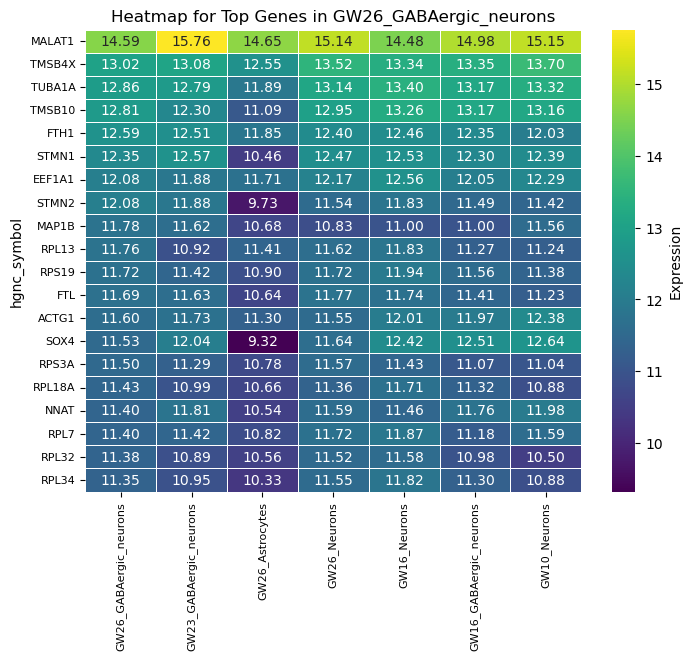

Index(['GENE', 'GW26_GABAergic_neurons', 'GW23_GABAergic_neurons',
       'GW26_Astrocytes', 'GW26_Neurons', 'GW16_Neurons',
       'GW16_GABAergic_neurons', 'GW10_Neurons', 'hgnc_symbol'],
      dtype='object')
             GW26_GABAergic_neurons  GW23_GABAergic_neurons  GW26_Astrocytes  \
hgnc_symbol                                                                    
MALAT1                    14.587485               15.756881        14.652924   
TMSB4X                    13.023209               13.076956        12.549743   
TUBA1A                    12.861615               12.794756        11.894083   
STMN1                     12.354867               12.570969        10.463619   
FTH1                      12.585571               12.509339        11.845242   
TMSB10                    12.812075               12.296909        11.089307   
SOX4                      11.532960               12.040358         9.324165   
STMN2                     12.083555               11.884680         

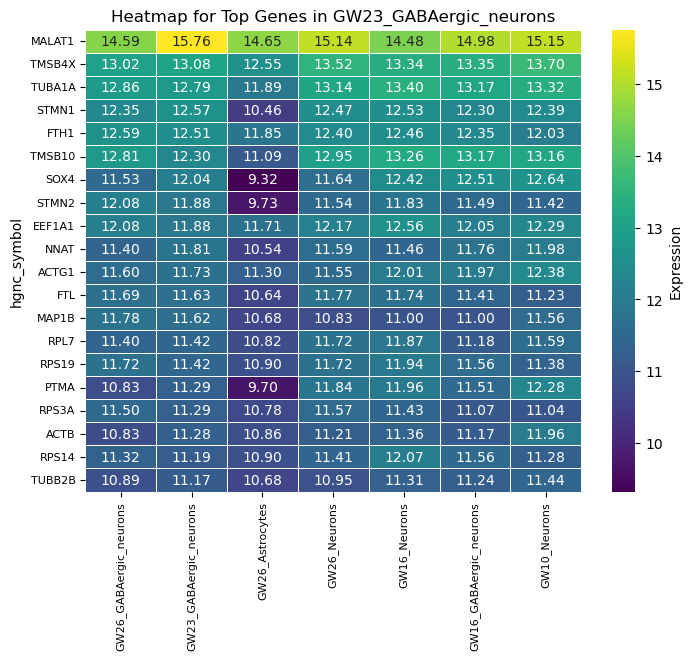

Index(['GENE', 'GW26_GABAergic_neurons', 'GW23_GABAergic_neurons',
       'GW26_Astrocytes', 'GW26_Neurons', 'GW16_Neurons',
       'GW16_GABAergic_neurons', 'GW10_Neurons', 'hgnc_symbol'],
      dtype='object')
             GW26_GABAergic_neurons  GW23_GABAergic_neurons  GW26_Astrocytes  \
hgnc_symbol                                                                    
MALAT1                    14.587485               15.756881        14.652924   
CST3                       7.883528                5.647353        13.506676   
TMSB4X                    13.023209               13.076956        12.549743   
PTN                        6.257114                4.378415        12.468385   
MIR9-1HG                   8.932971                8.296880        12.148346   
FABP7                      7.970256                6.505032        12.088046   
TUBA1A                    12.861615               12.794756        11.894083   
FTH1                      12.585571               12.509339        1

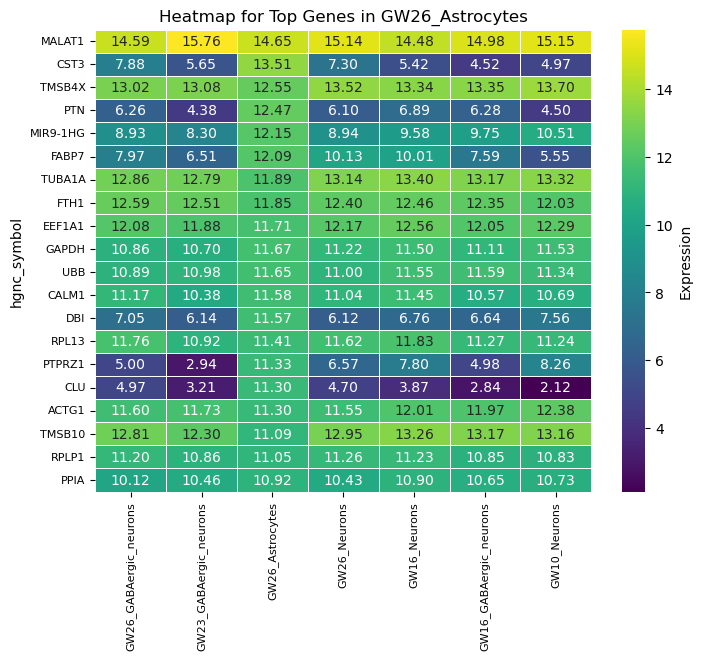

Index(['GENE', 'GW26_GABAergic_neurons', 'GW23_GABAergic_neurons',
       'GW26_Astrocytes', 'GW26_Neurons', 'GW16_Neurons',
       'GW16_GABAergic_neurons', 'GW10_Neurons', 'hgnc_symbol'],
      dtype='object')
             GW26_GABAergic_neurons  GW23_GABAergic_neurons  GW26_Astrocytes  \
hgnc_symbol                                                                    
MALAT1                    14.587485               15.756881        14.652924   
TMSB4X                    13.023209               13.076956        12.549743   
TUBA1A                    12.861615               12.794756        11.894083   
TMSB10                    12.812075               12.296909        11.089307   
STMN1                     12.354867               12.570969        10.463619   
FTH1                      12.585571               12.509339        11.845242   
EEF1A1                    12.084734               11.875467        11.712796   
PTMA                      10.832942               11.293790         

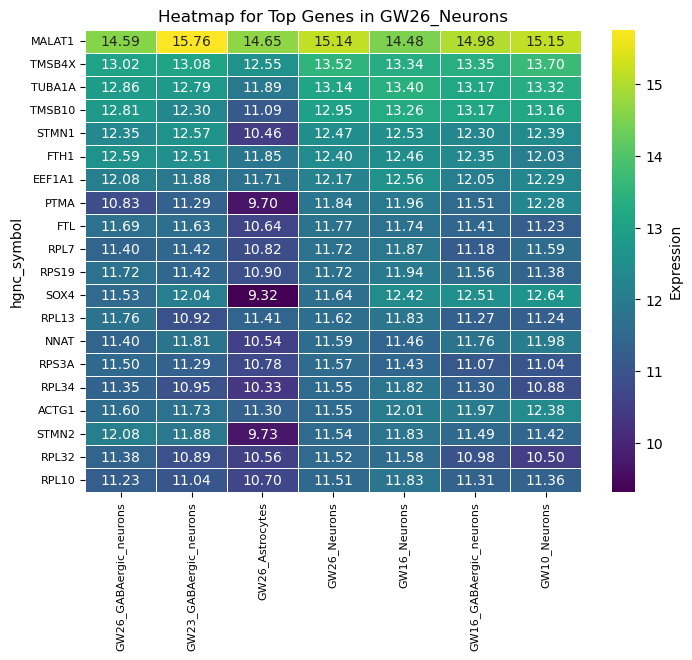

Index(['GENE', 'GW26_GABAergic_neurons', 'GW23_GABAergic_neurons',
       'GW26_Astrocytes', 'GW26_Neurons', 'GW16_Neurons',
       'GW16_GABAergic_neurons', 'GW10_Neurons', 'hgnc_symbol'],
      dtype='object')
             GW26_GABAergic_neurons  GW23_GABAergic_neurons  GW26_Astrocytes  \
hgnc_symbol                                                                    
MALAT1                    14.587485               15.756881        14.652924   
TUBA1A                    12.861615               12.794756        11.894083   
TMSB4X                    13.023209               13.076956        12.549743   
TMSB10                    12.812075               12.296909        11.089307   
EEF1A1                    12.084734               11.875467        11.712796   
STMN1                     12.354867               12.570969        10.463619   
FTH1                      12.585571               12.509339        11.845242   
SOX4                      11.532960               12.040358         

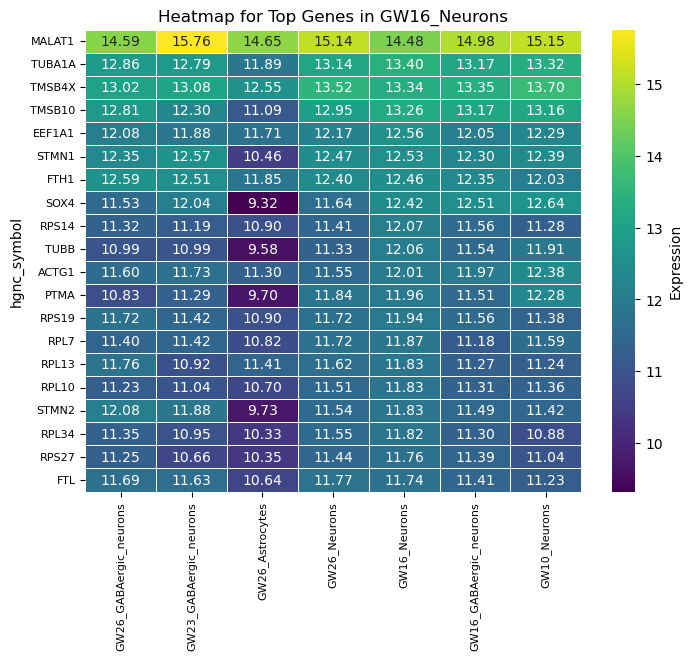

Index(['GENE', 'GW26_GABAergic_neurons', 'GW23_GABAergic_neurons',
       'GW26_Astrocytes', 'GW26_Neurons', 'GW16_Neurons',
       'GW16_GABAergic_neurons', 'GW10_Neurons', 'hgnc_symbol'],
      dtype='object')
             GW26_GABAergic_neurons  GW23_GABAergic_neurons  GW26_Astrocytes  \
hgnc_symbol                                                                    
MALAT1                    14.587485               15.756881        14.652924   
TMSB4X                    13.023209               13.076956        12.549743   
TMSB10                    12.812075               12.296909        11.089307   
TUBA1A                    12.861615               12.794756        11.894083   
SOX4                      11.532960               12.040358         9.324165   
FTH1                      12.585571               12.509339        11.845242   
STMN1                     12.354867               12.570969        10.463619   
EEF1A1                    12.084734               11.875467        1

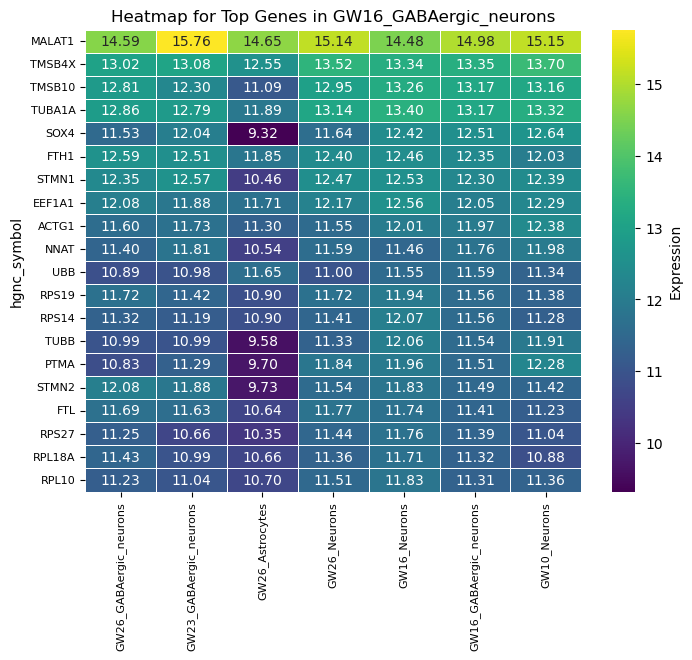

Index(['GENE', 'GW26_GABAergic_neurons', 'GW23_GABAergic_neurons',
       'GW26_Astrocytes', 'GW26_Neurons', 'GW16_Neurons',
       'GW16_GABAergic_neurons', 'GW10_Neurons', 'hgnc_symbol'],
      dtype='object')
             GW26_GABAergic_neurons  GW23_GABAergic_neurons  GW26_Astrocytes  \
hgnc_symbol                                                                    
MALAT1                    14.587485               15.756881        14.652924   
TMSB4X                    13.023209               13.076956        12.549743   
TUBA1A                    12.861615               12.794756        11.894083   
TMSB10                    12.812075               12.296909        11.089307   
SOX4                      11.532960               12.040358         9.324165   
STMN1                     12.354867               12.570969        10.463619   
ACTG1                     11.596577               11.732562        11.297154   
EEF1A1                    12.084734               11.875467        1

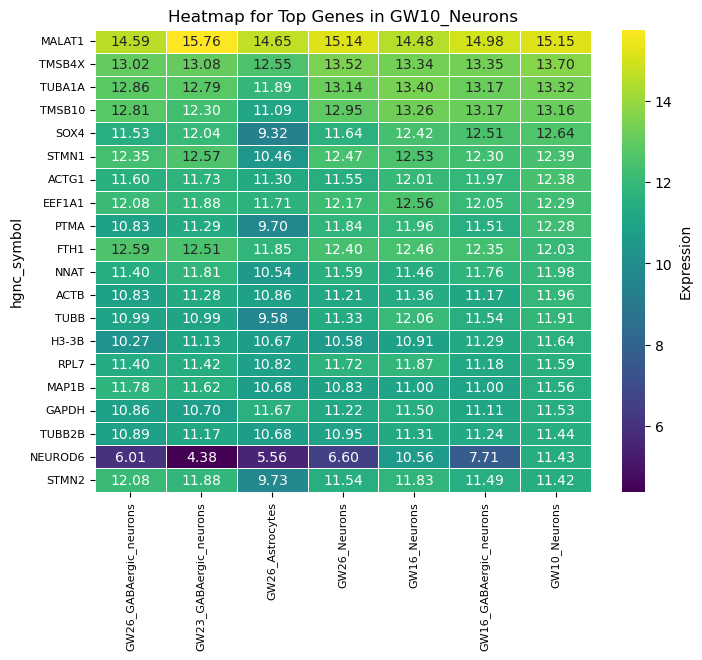

In [23]:
 # Iterate through each df in top_genes_dict_with_names
for cell_type, current_df in top_genes_dict_with_names.items():
    #set index as hgnc_symbol
    #current_df.reset_index(drop=True,inplace=True)
    print(current_df.columns)
    current_df.set_index(['hgnc_symbol'], inplace=True)
    current_df.drop(columns=['GENE'], inplace=True)
    print(current_df)
    # Set the size of the plotting device
    plt.figure(figsize=(8, 6))

    # Create heatmap with title
    sns.heatmap(current_df, 
                cmap='viridis',  # Choose colormap
                annot=True,  # Show values on heatmap
                fmt=".2f",  # Format of annotation
                linewidths=.5, 
                cbar_kws={'label': 'Expression'},  # Label for color bar
                )
    
    # Add title
    plt.title("Heatmap for Top Genes in " + cell_type)
    
    # Adjust fontsize of row and column labels
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    
    # Show plot
    plt.show()   



- MALAT1 is highly expressed in all cell types consistent with literature where it is highly expressed in the brain

## Overlap of Most Highly Expressed Genes in Cell Types

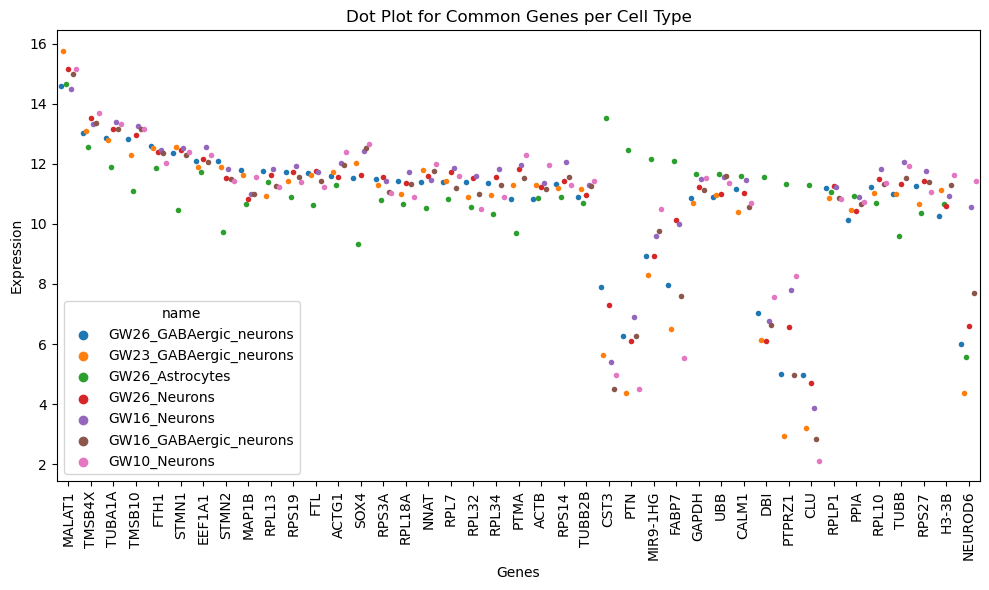

41


In [7]:
# Combine all top 20 lists into a single DataFrame
combined_top_genes_df = pd.concat(top_genes_dict_with_names.values())
#remove index column
combined_top_genes_df.drop(columns=['index'], inplace=True)
# Reset the index to convert 'hgnc_symbol' from index to a regular column
combined_top_genes_df.reset_index(inplace=True)

# Melt the DataFrame
reshaped_top_genes_df = combined_top_genes_df.melt(id_vars=['hgnc_symbol'], var_name='name', value_name='expression')

# Keep only unique combinations of cell type and gene name
reshaped_top_genes_df = reshaped_top_genes_df.drop_duplicates(subset=['hgnc_symbol', 'name'])

# Visualize with a dot plot for each data point
plt.figure(figsize=(10, 6))
sns.stripplot(data=reshaped_top_genes_df, x='hgnc_symbol', y='expression', hue='name', dodge=True, size=4)
plt.xticks(rotation=90)
plt.xlabel('Genes')
plt.ylabel('Expression')
plt.title('Dot Plot for Common Genes per Cell Type')
plt.tight_layout()
plt.show()

# Identify number of genes found in all cell types
num_common_genes = combined_top_genes_df['hgnc_symbol'].nunique()
print(num_common_genes)

In [8]:
## Overlap with GWAS data?

In [9]:
#Read in mapped genes from GWAS and all genes for zhong expression
#select relevant working directory
os.chdir('C:/Users/fallo/OneDrive/Documents/URF_2023/Datasets')
gwas_genes = pd.read_csv('SCZ_GWAS_mapped_genes.txt', sep="\t")

exp_genes = pd.read_csv('zhong_exp_sig_cells.csv')

## Plot a venn diagram for overlap of genes

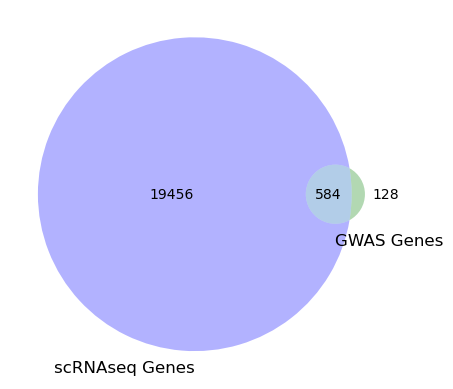

In [10]:
# Extract gene names from the data frames
exp_genes_list = set(exp_genes['SYMBOL'])
gwas_genes_list = set(gwas_genes['symbol'])

# Calculate the sizes of the intersection and unique sets
intersection_size = len(exp_genes_list.intersection(gwas_genes_list))
exp_unique_size = len(exp_genes_list - gwas_genes_list)
gwas_unique_size = len(gwas_genes_list - exp_genes_list)


# Create a Venn diagram
venn_diagram = venn2(subsets=(exp_unique_size, gwas_unique_size, intersection_size), 
                     set_labels=('scRNAseq Genes', 'GWAS Genes'),
                     set_colors=('blue', 'green'), alpha=0.3)

# Adjust text position to prevent overlap
gwas_label = venn_diagram.get_label_by_id('01')  # Get the label for the GWAS circle

# Adjust the x-coordinate for the GWAS label
gwas_label.set_x(gwas_label.get_position()[0] + 0.1)